# Gravity

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/particles/Gravity.ipynb)

This example simulates Newtonian gravity between planets.

In [1]:
%pip install --quiet phiflow
from phi.jax.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.

Let's define the initial positions for our planets.
We stack the position vectors of the planets a long a new [*instance*](https://tum-pbs.github.io/PhiFlow/Math.html#shapes) dimension we call *planets*.
Φ<sub>Flow</sub> also allows us to name the individual elements along that dimension. These names are part of the shape and will be present on all tensors derived from `x` that have this dimension.

c:\phd\phiflow2\phiml\phiml\backend\_backend.py:1632: RuntimeWarning: invalid value encountered in power
  return base ** exp


<Figure size 864x360 with 1 Axes>

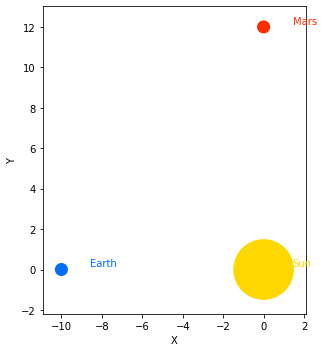

In [18]:
x0 = stack({
    'Sun': vec(x=0, y=0),
    'Earth': vec(x=-10, y=0),
    'Mars': vec(x=0, y=12)}, instance('planets'))
mass = wrap([1000, 10, 10], instance(x0))
color = wrap(['#fcd700', '#006dfc', '#fc2e00'], instance(x0))
plot(Sphere(x0, radius=mass**(1/3)*.15), color=color)

Next, we define the simulation step, advancing `x` and `v` in time by $\Delta t$.
The acceleration is given by $a = G \cdot \sum_i \frac{m_i \cdot \vec r_i}{r_i^3}$.
Inside the step, `math.pairwise_distances` computes all body-body distance vectors, adding a new dual dimension called `~planets`.

In [9]:
@jit_compile
def step(x, v, dt=.5):
    dx = math.pairwise_differences(x)
    a = .01 * math.sum(math.safe_div(mass.planets.as_dual() * dx, math.vec_squared(dx) ** 1.5), '~planets')
    return x + v * dt, v + a * dt

Let's run the simulation. We set the initial velocity to be perpendicular to the position from the sun, so planets are on a circular orbit.

In [20]:
v0 = math.safe_div(math.rotate_vector(x0, PI/2), math.vec_length(x0))
x_trj, v_trj = iterate(step, batch(time=100), tensor(x0), v0)
plot(Sphere(x_trj, radius=mass**(1/3)*.2), color=color, animate='time')